In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from yellowbrick.text import PosTagVisualizer
from fast_ml.model_development import train_valid_test_split

In [2]:
def load_data():
    column_names = ["target", "ids", "date", "flag", "user", "text"]
    df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", names=column_names, encoding='ISO-8859-1')
    display(df)
    return df

df = load_data()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

In [31]:
negative_tweets = df[df.iloc[:, 0] == 0]
negative_tweets.shape

(800000, 2)

In [32]:
positive_tweets = df[df.iloc[:, 0] == 4]
positive_tweets.shape

(800000, 2)

target    0.0
ids       0.0
date      0.0
flag      0.0
user      0.0
text      0.0
dtype: float64
Nombres de tweets dupliqués :  18534
col = target -> duplicated = 1599998
col = ids -> duplicated = 1685
col = date -> duplicated = 825637
col = flag -> duplicated = 1599999
col = user -> duplicated = 940225
col = text -> duplicated = 18534


0          False
1          False
2          False
3          False
4          False
           ...  
1599995    False
1599996    False
1599997    False
1599998    False
1599999    False
Name: text, Length: 1600000, dtype: bool


,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


,date,flag,user,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


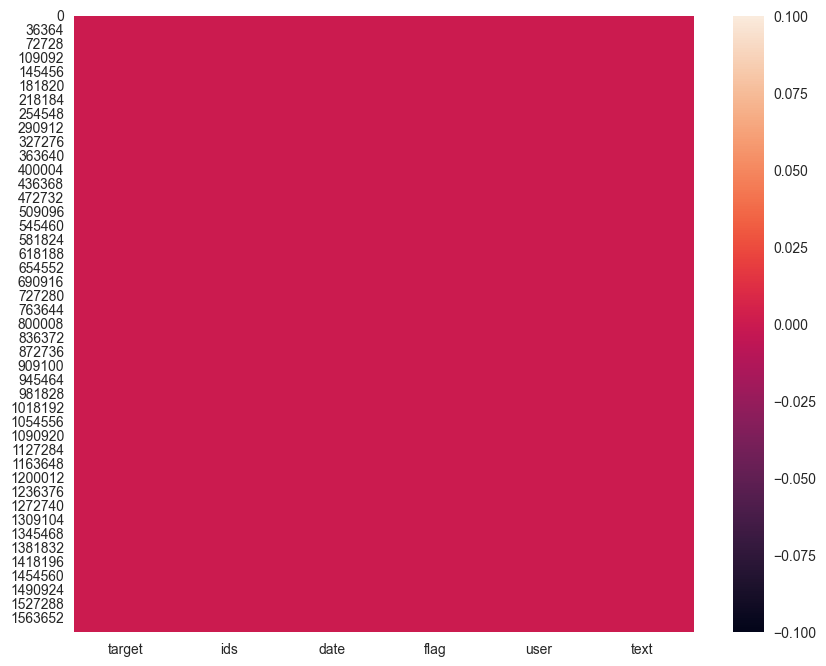

In [6]:
def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print("Nombres de tweets dupliqués : ", data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))

analyse_data(df)

Text(0.5, 1.0, 'Distribution du nombre de caractères des tweets')

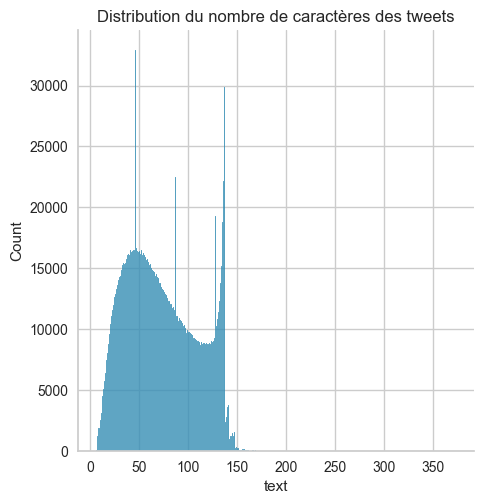

In [7]:
tmp = df.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des tweets")

In [27]:
def drop_columns(df):
    df = df[['target', 'text']]
    return df

df = drop_columns(df)
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [30]:
def display_tokens_info(tokens):
    """display info about corpus"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])
eng_words = nltk.corpus.words.words()
display_tokens_info(eng_words)

nb tokens 236736, nb tokens uniques 235892
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [ ]:
ps = nltk.PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]
display_tokens_info(eng_words_stem)

In [24]:
"""
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
"""

"\nnltk.download('omw-1.4')\nnltk.download('wordnet')\nnltk.download('stopwords')\nnltk.download('words')\n"

In [ ]:
def process_text_5(doc,
                   rejoin=False,
                   lemm_or_stemm="stem",
                   list_rare_words=None,
                   min_len_word=3,
                   force_is_alpha=True,
                   eng_words=False,
                   extra_words=None):
    """cf process_text_1 but with list unique word, min_len_word, and force_is_alpha"""


    #lower
    doc = doc.lower().strip()

    #tokenize
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    #classic stopwords
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    #no rare tokens
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]

    #no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    #only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    #lemm or stemm
    if lemm_or_stemm == "lem":
        trans = nltk.WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else:
        trans = nltk.PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]

    #in english
    if eng_words:
        engl_text = [i for i in trans_text if i in eng_words]
    else:
        engl_text = trans_text

    ########################################################################
    ########################################################################

    final = [w for w in eng_words if w not in extra_words]

    ########################################################################
    ########################################################################

    #manage return type
    if rejoin:
        return " ".join(final)

    return final

In [ ]:
def final_clean(doc):
    new_doc = process_text_5(doc,
                             rejoin=True,
                             lemm_or_stemm="stem",
                             list_rare_words=list_5_words,
                             eng_words=eng_words_stem,
                             extra_words=doublons)
    return new_doc

In [21]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'target',
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1280000, 5)
(1280000,)
(160000, 5)
(160000,)
(160000, 5)
(160000,)


(None, None)